# Wavelet Significance Testing Methods Development

This is the development notebook of the normalization of the CWT spectra. The disagreements between the literature and the values found here, inconsistencies between libraries (i.e., between pycwt and the R package and the fortran code from TC98), and inconsistencies when comparing the spectra of different instruments in my own analysis motivate this exploration.

See the other notebooks for literature references.

1) Standardize the signal or scale the global power by variance. One or the other must be comleted.

2) Scale the wavelet spectra by sqrt($\delta t$). This step is only necessary when comparing a) data that have different time steps and variances or b) when comparing to an fft routine that gives spectral density. Note that this scaling does not give the spectra units of power but units of power / frequency (I think).

In [1]:
# Math libraries
import numpy as np
import colorednoise as cn
import pycwt
import scipy.integrate as integrate

# OS interaction
import sys
# Add the other files from these helper functions
sys.path.append('../helper_functions')
sys.path.append('../figures')

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Local pycwt helper functions
import pycwt_stat_helpers as cwt_stat
import pycwt_plot_helpers as cwt_plt

# Format plots

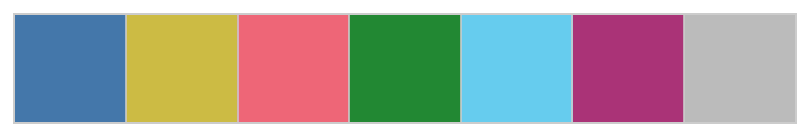

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context("paper")

# Define a default color palette (this should be fairly color blind friendly)
tol_bright_reorder = ['#4477AA', '#CCBB44', '#EE6677', '#228833', '#66CCEE', '#AA3377', '#BBBBBB']
sns.set_palette(sns.color_palette(tol_bright_reorder))
sns.palplot(sns.color_palette(tol_bright_reorder))

# Wavelet normalization

## First, implement some colored noise to test spectra

Generate:

1) White noise

2) Red noise

3) Pink noise

Note: these are generated to have the properties of an "infinitely" long sampled process. This is a theoretical advantage over directly simulating random number generator for white noise or using a Markov chain to model the red noise.

Text(0.5, 1.0, 'Colored noise for anlaysis')

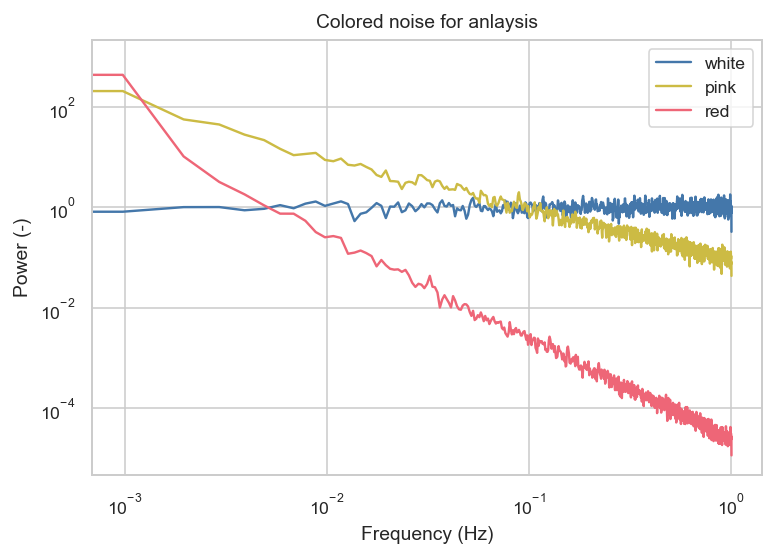

In [3]:
beta = 1 # the exponent
N = 50000 # number of samples to generate
y_white = cn.powerlaw_psd_gaussian(0, N)
y_pink = cn.powerlaw_psd_gaussian(1, N)
y_red = cn.powerlaw_psd_gaussian(2, N)

# optionally plot the Power Spectral Density with Matplotlib
from matplotlib import mlab
s, f = mlab.psd(y_white, NFFT=2**11)
plt.loglog(f, s, label='white')

s, f = mlab.psd(y_pink, NFFT=2**11)
plt.loglog(f, s, label='pink')

s, f = mlab.psd(y_red, NFFT=2**11)
plt.loglog(f, s, label='red')
plt.gca().legend()
plt.gca().set_ylabel('Power (-)')
plt.gca().set_xlabel('Frequency (Hz)')
plt.gca().set_title('Colored noise for anlaysis')

### A quick test of the standardization function

I noticed several bugs/misimplementations that have now been fixed. The resulting time series all have a variance of 1, which is the desired behavior.

Variance after standardizing (original, 1 sigma data)
1.0
Variance after standardizing (modified, 2 sigma data)
1.0


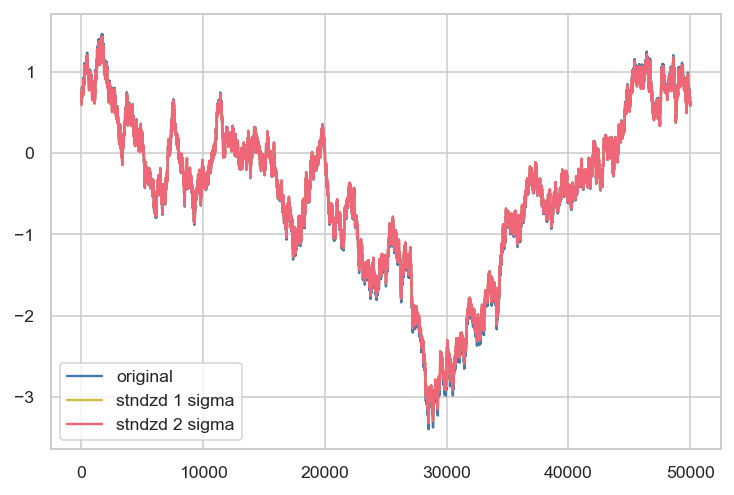

In [4]:
signal = y_red
plt.figure()
plt.plot(signal, label='original')

signal_norm = cwt_stat.standardize(signal, **{'standardize': True, 'detrend': False})
plt.plot(signal_norm, label='stndzd 1 sigma')
print('Variance after standardizing (original, 1 sigma data)')
print(np.std(signal_norm) ** 2)

signal_norm = cwt_stat.standardize(signal * 2, **{'standardize': True, 'detrend': False})
plt.plot(signal_norm, label='stndzd 2 sigma')
print('Variance after standardizing (modified, 2 sigma data)')
print(np.std(signal_norm) ** 2)
plt.gca().legend()


Incorrect variance (no standardization after detrending)
1.0361352357147358
Correct variance (standardizing after detrending)
1.0


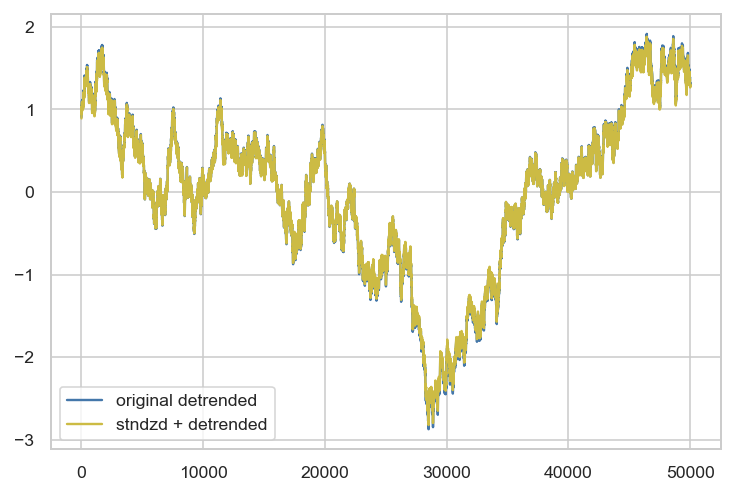

In [5]:
signal = y_red
plt.figure()

signal_norm = cwt_stat.standardize(signal, **{'standardize': False, 'detrend': True})
plt.plot(signal_norm, label='original detrended')
print('Incorrect variance (no standardization after detrending)')
print(np.std(signal_norm) ** 2)

signal_norm = cwt_stat.standardize(signal, **{'standardize': True, 'detrend': True})
plt.plot(signal_norm, label='stndzd + detrended')
print('Correct variance (standardizing after detrending)')
print(np.std(signal_norm) ** 2)
plt.gca().legend()

# Item 2) Scaling by the time step

Rectification of the spectra must be turned off in order to allow this comparison.

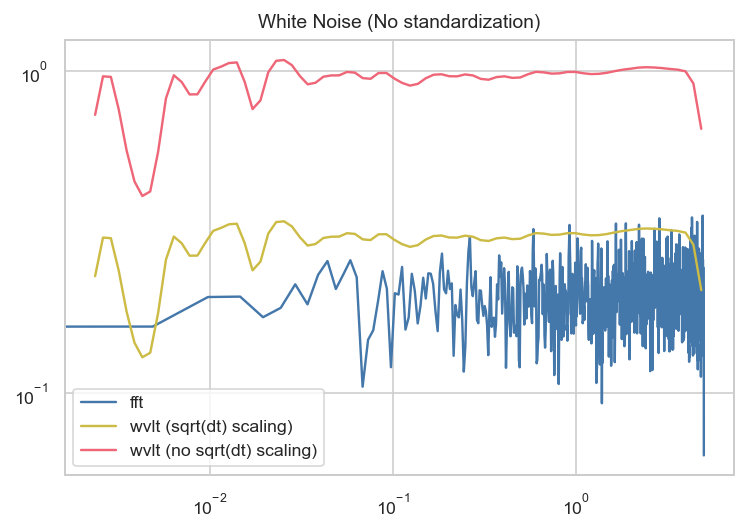

In [6]:
s, f = mlab.psd(y_white, NFFT=2**11, Fs=10)
plt.loglog(f, s / np.std(y_white) ** 2, label='fft')

mother = pycwt.Morlet()
dt = 0.1
time = np.arange(0, N * dt, dt)
octaves = [1 / 7, 11 / (1 / 7)]  

signal = y_white
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_white,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=np.std(y_white) ** 2,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False},
    significance_test=False,
)

plt.loglog(1 / period, glbl_power_white * np.sqrt(dt), label='wvlt (sqrt(dt) scaling)')
plt.loglog(1 / period, glbl_power_white, label='wvlt (no sqrt(dt) scaling)')

plt.gca().set_title('White Noise (No standardization)')
plt.gca().legend()

# Item 1) Standardizing spectra of white noise

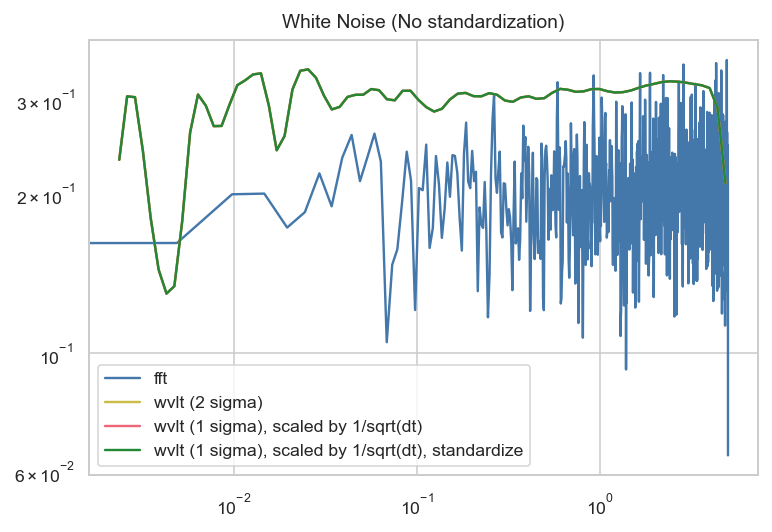

In [7]:
s, f = mlab.psd(y_white, NFFT=2**11, Fs=10)
plt.loglog(f, s / np.std(y_white) ** 2, label='fft')

mother = pycwt.Morlet()
dt = 0.1
time = np.arange(0, N * dt, dt)
octaves = [1 / 7, 11 / (1 / 7)]  

# 2 sigma
signal = y_white * 2
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_white,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=np.std(y_white * 2) ** 2,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False},
    significance_test=False,
)
plt.loglog(1 / period, glbl_power_white * np.sqrt(dt), label='wvlt (2 sigma)')

# 1 sigma
signal = y_white
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_white,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    variance=np.std(y_white) ** 2,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False},
    significance_test=False,
)
plt.loglog(1 / period, glbl_power_white * np.sqrt(dt), label='wvlt (1 sigma), scaled by 1/sqrt(dt)')

# 1 sigma
signal = y_white
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_white,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=False,
    norm_kwargs={'standardize': True, 'detrend': False},
    significance_test=False,
)
plt.loglog(1 / period, glbl_power_white * np.sqrt(dt), label='wvlt (1 sigma), scaled by 1/sqrt(dt), standardize')

plt.gca().set_title('White Noise (No standardization)')
plt.gca().legend()

Not quite a perfect recreation of the underlying fft spectra, but very close. The different options of normalizing the wavelet spectra collapse on top of each other.

# Item 1) Standardizing spectra of red noise

## Examples of the problems 

All of these spectra should be identical. First, an example of what happens if no care is taken for the scaling and standardization.

Text(0.5, 1.0, 'Red Noise (No standardization)')

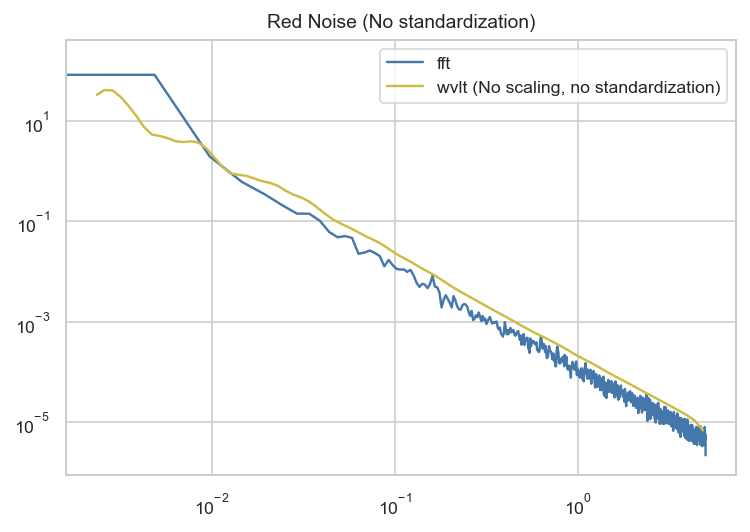

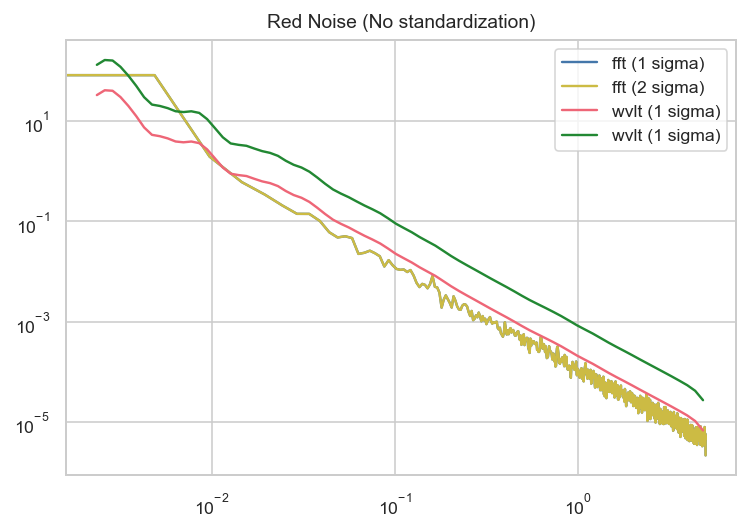

In [8]:
s, f = mlab.psd(y_red, NFFT=2**11, Fs=10)
plt.loglog(f, s / np.std(y_red) ** 2, label='fft')

mother = pycwt.Morlet()
dt = 0.1
time = np.arange(0, N * dt, dt)
octaves = [1 / 7, 11 / (1 / 7)]  

# 1 sigma
signal = y_red
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_red,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=False,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False},
    variance=1,
    significance_test=False,
)
plt.loglog(1 / period, glbl_power_red * np.sqrt(dt), label='wvlt (No scaling, no standardization)')

plt.gca().set_title('Red Noise')
plt.gca().legend()
plt.gca().set_title('Red Noise (No standardization)')

# And now comparing different standard deviations
plt.figure()
s, f = mlab.psd(y_red, NFFT=2**11, Fs=10)
plt.loglog(f, s / np.std(y_red) ** 2, label='fft (1 sigma)')

s, f = mlab.psd(y_red * 2, NFFT=2**11, Fs=10)
plt.loglog(f, s / np.std(y_red * 2) ** 2, label='fft (2 sigma)')

mother = pycwt.Morlet()
dt = 0.1
time = np.arange(0, N * dt, dt)
octaves = [1 / 7, 11 / (1 / 7)]  

# 1 sigma
signal = y_red
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_red,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=False,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False},
    variance=1,
    significance_test=False,
)
plt.loglog(1 / period, glbl_power_red * np.sqrt(dt), label='wvlt (1 sigma)')

# 2 sigma
signal = y_red * 2
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_red,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=False,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False},
    variance=1,
    significance_test=False,
)
plt.loglog(1 / period, glbl_power_red * np.sqrt(dt), label='wvlt (1 sigma)')

plt.gca().set_title('Red Noise')
plt.gca().legend()
plt.gca().set_title('Red Noise (No standardization)')

The FFT and wavelet spectra do not align with each other. This problem becomes even more apparent when trying to compare spectra with different standard deviations (second plot). All of the spectra should be aligned with each other.

## Now with standardization/variance scaling of the global spectra

Text(0.5, 1.0, 'Red Noise (No standardization)')

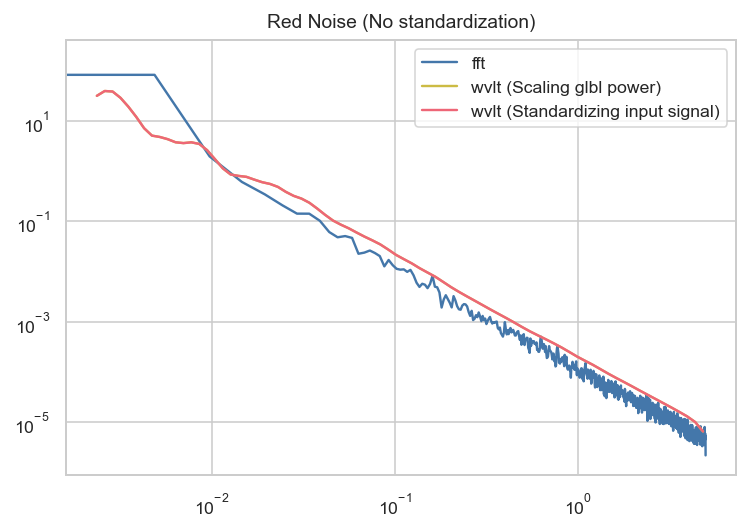

In [9]:
s, f = mlab.psd(y_red, NFFT=2**11, Fs=10)
plt.loglog(f, s / np.std(y_red) ** 2, label='fft')

mother = pycwt.Morlet()
dt = 0.1
time = np.arange(0, N * dt, dt)
octaves = [1 / 7, 11 / (1 / 7)]  

# 1 sigma
signal = y_red
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_red,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False},
    variance=np.std(y_red) ** 2,
    significance_test=False,
)
plt.loglog(1 / period, glbl_power_red * np.sqrt(dt), label='wvlt (Scaling glbl power)')

# 1 sigma
signal = y_red
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_red,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=False,
    rectify=False,
    norm_kwargs={'standardize': True, 'detrend': False},
    variance=np.std(y_red) ** 2,
    significance_test=False,
)
plt.loglog(1 / period, glbl_power_red * np.sqrt(dt), label='wvlt (Standardizing input signal)')

plt.gca().set_title('Red Noise')
plt.gca().legend()
plt.gca().set_title('Red Noise (No standardization)')

The two wavelet spectra are for scaling the global spectra by the variance (gold) and for standardizing the input signal (red). Reassuringly, they collapse on top of each other.

## Demonstrating that this works for different amplitudes of data

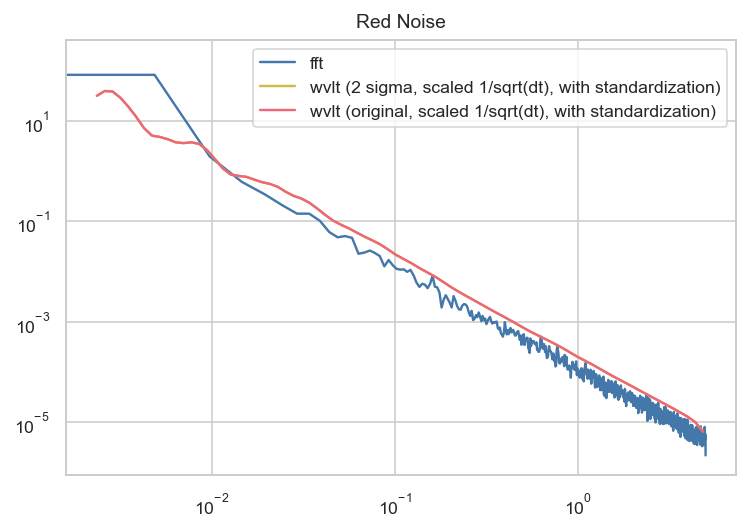

In [10]:
s, f = mlab.psd(y_red, NFFT=2**11, Fs=10)
plt.loglog(f, s / np.std(y_red) ** 2, label='fft')

mother = pycwt.Morlet()
dt = 0.1
time = np.arange(0, N * dt, dt)
octaves = [1 / 7, 11 / (1 / 7)]  

# 2 sigma (with standardization)
signal = y_red * 2
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_red,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False},
    variance=np.std(y_red * 2) ** 2,
    significance_test=False,
)
plt.loglog(1 / period, glbl_power_red * np.sqrt(dt), label='wvlt (2 sigma, scaled 1/sqrt(dt), with standardization)')

# 1 sigma
signal = y_red
(signal_norm, period, coi,
 power, glbl_signif, glbl_power_red,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, time, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False},
    variance=np.std(y_red) ** 2,
    significance_test=False,
)
plt.loglog(1 / period, glbl_power_red * np.sqrt(dt), label='wvlt (original, scaled 1/sqrt(dt), with standardization)')

plt.gca().set_title('Red Noise')
plt.gca().legend()

As before the wavelet spectra collapse onto each other. There is a slight disagreement with the fft spectra, but it is close enough that I am no longer concerned.

# Test the normalization

Both integrations should be close to 1 after normalizing by the variance.


In [11]:
print('FFT/sigma**2 = {:1.2f}'.format(integrate.trapezoid(s / np.std(y_red) ** 2, f)))
print(
    'CWT/sigma**2 / sqrt(dt) = {:1.2f}'.format(
        integrate.trapezoid(
            np.flip(glbl_power_red) / np.std(y_red) ** 2,
            np.flip(1 / period)
        )
    )
)


FFT/sigma**2 = 0.81
CWT/sigma**2 / sqrt(dt) = 0.27


It is a bit inexplicable to me why the trapezoid integration technique cares about the order of the arrays (needs to be increasing instead of decreasing, hence the flipping). If I don't flip the arrays I get a negative value, which is nonsense as nothing has a value below zero.

This behavior turns out to be "expected"...

https://stackoverflow.com/questions/36803745/python-simpsons-rule-negative-answer-for-positive-area-under-the-curve

Regardless, the values are approximately correct with the wavelets actually getting closer to the correct normalization. I didn't expect that!